In [17]:
import mlxtend
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import pandas_ml
from pandas_ml import ConfusionMatrix

In [19]:
import os
from sklearn.utils import shuffle
import glob
import sys
################### DATASET HANDLING ####################
DATASET_PATH = "/home/dic/jupyter/train_binary8" #change the path to your dataset folder here

def parseDataset():
 
    #we use subfolders as class labels
    classes = [folder for folder in sorted(os.listdir(DATASET_PATH))]
 
    #now we enlist all image paths
    images = []
    for c in classes:
        images += ([os.path.join(DATASET_PATH, c, path) for path in os.listdir(os.path.join(DATASET_PATH, c))])
    #print(images)
    #shuffle image paths
    images = shuffle(images, random_state=74)
 
    #we want to use a 15% validation split
    total_len=len(images)
    print("total:",total_len)
    vsplit = int(len(images) * 0.60) #=40
    print("vsplit:",vsplit)
    
    tsplit= int(total_len-vsplit)
    print("tsplit:",tsplit)
    
    gsplit=int(tsplit/2)
    print(gsplit)
    msplit=int(vsplit+gsplit)
    
    
    train = images[:vsplit] #everything except the last vsplit items in the array 
    val = images[vsplit:msplit]  #only last vsplit items from the array
    test=images[msplit:]
    #show some stats
    print ("CLASS LABELS:", classes)
    print ("TRAINING IMAGES:", len(train))
    print ("VALIDATION IMAGES:", len(val))
    print ("TEST IMAGES:", len(test))
    return classes, train, val,test
 
#parse dataset
CLASSES, TRAIN, VAL,TEST = parseDataset()


total: 44427
vsplit: 26656
tsplit: 17771
8885
CLASS LABELS: ['RRLYR', 'T2CEP']
TRAINING IMAGES: 26656
VALIDATION IMAGES: 8885
TEST IMAGES: 8886


In [20]:
import lasagne
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh

In [21]:
import os
import time
from sklearn.utils import shuffle

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
import itertools

from lasagne import random as lasagne_random
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh
from lasagne import objectives
from lasagne import updates

import theano
import theano.tensor as T

import warnings
warnings.filterwarnings("ignore")


In [22]:
from lasagne import layers
from lasagne.nonlinearities import softmax, tanh
 
################## BUILDING THE MODEL ###################
def buildModel():
    #this is our input layer with the inputs (None, dimensions, width, height)
    l_input = layers.InputLayer((None, 3, 22, 23))
    
    #first convolutional layer, has l_input layer as incoming and is followed by a pooling layer
    l_conv1 = layers.Conv2DLayer(l_input, num_filters=32, filter_size=3, nonlinearity=lasagne.nonlinearities.tanh)
    
    #l_pool = layers.MaxPool2DLayer(l_conv1, pool_size=2)
    
    l_drop1= layers.DropoutLayer(l_conv1,  p=0.1)
    
    #l_dense1 = layers.DenseLayer(l_drop1, num_units=128)
    
    #l_conv2 = layers.Conv2DLayer(l_drop1, num_filters=128, filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
    
   
    #l_conv3 = layers.Conv2DLayer(l_conv2, num_filters=256, filter_size=5, nonlinearity=lasagne.nonlinearities.rectify)
    
    l_dense2 = layers.DenseLayer(l_drop1, num_units=128)
    
    l_drop2= layers.DropoutLayer(l_dense2,  p=0.25)
    
    l_dense2 = layers.DenseLayer(l_drop2, num_units=128)
    
    l_output = layers.DenseLayer(l_dense2, num_units=2, nonlinearity=lasagne.nonlinearities.softmax)
    
    #let's see how many params our net has
    print ("MODEL HAS", layers.count_params(l_output), "PARAMS")
    
    #we return the layer stack as our network by returning the last layer
    return l_output


NET = buildModel()


MODEL HAS 1738114 PARAMS


In [23]:
from lasagne import objectives
 
import theano
import theano.tensor as T
 
#################### LOSS FUNCTION ######################
def calc_loss(prediction, targets):
 
    #categorical crossentropy is the best choice for a multi-class softmax output
    l = T.mean(objectives.categorical_crossentropy(prediction, targets))
    
    return l
 
#theano variable for the class targets
#this is the output vector the net should predict
targets = T.matrix('targets', dtype=theano.config.floatX)
 
#get the network output
prediction = layers.get_output(NET)
 
#calculate the loss
loss = calc_loss(prediction, targets)

In [24]:
################# ACCURACY FUNCTION #####################
def calc_accuracy(prediction, targets):
 
    #we can use the lasagne objective categorical_accuracy to determine the top1 accuracy
    a = T.mean(objectives.categorical_accuracy(prediction, targets, top_k=1))
    
    return a
 
accuracy = calc_accuracy(prediction, targets)

In [25]:
from lasagne import updates
 
####################### UPDATES #########################
#get all trainable parameters (weights) of our net
params = layers.get_all_params(NET, trainable=True)
 
#we use the adam update
#it changes params based on our loss function with the learning rate
param_updates = updates.adam(loss, params, learning_rate=0.0002)

In [26]:
import theano
#################### TRAIN FUNCTION ######################
#the theano train functions takes images and class targets as input
#it updates the parameters of the net and returns the current loss as float value
#compiling theano functions may take a while, you might want to get a coffee now...
print ("COMPILING THEANO TRAIN FUNCTION...",)
train_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], loss, updates=param_updates)
print ("DONE!")
 
################# PREDICTION FUNCTION ####################
#we need the prediction function to calculate the validation accuracy
#this way we can test the net after training
#first we need to get the net output
net_output = layers.get_output(NET)
 
#now we compile another theano function; this may take a while, too
print ("COMPILING THEANO TEST FUNCTION...",)
test_net = theano.function([layers.get_all_layers(NET)[0].input_var, targets], [net_output, loss, accuracy])
print ("DONE!")

COMPILING THEANO TRAIN FUNCTION...
DONE!
COMPILING THEANO TEST FUNCTION...
DONE!


In [27]:
import cv2
import numpy as np
 
#################### BATCH HANDLING #####################
def loadImageAndTarget(path):
    #print(path)
    #here we open the image and scale it to 64x64 pixels
    img = cv2.imread(path)
    
    #print(path)
    img = cv2.resize(img, (22, 23))
    
    
    #OpenCV uses BGR instead of RGB, but for now we can ignore that
    #our image has the shape (64, 64, 3) but we need it to be (3, 64, 64)
    img = np.transpose(img, (2, 1, 0))
    
    #we want to use subfolders as class labels
    label = path.split(os.sep[-1])[-2]
    #print(label)
 
    #we need to get the index of our label from CLASSES
    index = CLASSES.index(label)
 
    #allocate array for target
    target = np.zeros((2), dtype='float32')
 
    #we set our target array = 1.0 at our label index, all other entries remain zero
    #Example: if label = dog and dog has index 2 in CLASSES, target looks like: [0.0, 0.0, 1.0, 0.0, 0.0]
    target[index] = 1.0
 
    #we need a 4D-vector for our image and a 2D-vector for our targets
    #we can adjust array dimension with reshape
    img = img.reshape(-1, 3, 22, 23)
    target = target.reshape(-1, 2)
 
    return img, target

In [28]:
#a reasonable size for one batch is 128
BATCH_SIZE = 500
def getDatasetChunk(split):
 
    #get batch-sized chunks of image paths
    for i in range(0, len(split), BATCH_SIZE):
        yield split[i:i+BATCH_SIZE]
        
def getNextImageBatch(split=TRAIN):    
 
    #allocate numpy arrays for image data and targets
    #input shape of our ConvNet is (None, 3, 22, 23)
    x_b = np.zeros((BATCH_SIZE, 3, 22, 23), dtype='float32')
    #output shape of our ConvNet is (None, 5) as we have 5 classes
    y_b = np.zeros((BATCH_SIZE, 2), dtype='float32')
 
    #fill batch
    for chunk in getDatasetChunk(split):        
        ib = 0
        for path in chunk:
            #load image data and class label from path
            x, y = loadImageAndTarget(path)
 
            #pack into batch array
            x_b[ib] = x
            y_b[ib] = y
            ib += 1
 
        #instead of return, we use yield
        yield x_b[:len(chunk)], y_b[:len(chunk)]

In [29]:

        
def getNextImageBatch1(split=TEST):    
 
    #allocate numpy arrays for image data and targets
    #input shape of our ConvNet is (None, 3, 22, 23)
    x_T = np.zeros((BATCH_SIZE, 3, 22, 23), dtype='float32')
    #output shape of our ConvNet is (None, 5) as we have 5 classes
    y_T = np.zeros((BATCH_SIZE, 2), dtype='float32')
 
    #fill batch
    for chunk in getDatasetChunk(split):        
        iT = 0
        for path in chunk:
            #load image data and class label from path
            x1, y1 = loadImageAndTarget(path)
 
            #pack into batch array
            x_T[iT] = x1
            y_T[iT] = y1
            iT += 1
 
        #instead of return, we use yield
        yield x_T[:len(chunk)], y_T[:len(chunk)]

In [30]:
cmatrix = []
def clearConfusionMatrix():

    global cmatrix

    #allocate empty matrix of size 5x5 (for our 5 classes)
    cmatrix = np.zeros((len(CLASSES), len(CLASSES)), dtype='int32')
    
    
def updateConfusionMatrix(t, p):
    
    global cmatrix
    cmatrix += confusion_matrix(np.argmax(t, axis=1), np.argmax(p, axis=1))
    
def showConfusionMatrix():

    #new figure
    plt.figure(1)
    plt.clf()

    #show matrix
    plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    #tick marks
    tick_marks = np.arange(len(CLASSES))
    plt.xticks(tick_marks, CLASSES)
    plt.yticks(tick_marks, CLASSES)

    #labels
    thresh = cmatrix.max() / 2.
    for i, j in itertools.product(range(cmatrix.shape[0]), range(cmatrix.shape[1])):
        plt.text(j, i, cmatrix[i, j], 
                 horizontalalignment="center",
                 color="white" if cmatrix[i, j] > thresh else "black")

    #axes labels
    plt.ylabel('Target label')
    plt.xlabel('Predicted label')

    #show
    plt.show()
    plt.pause(0.5)   


In [31]:
import matplotlib.pyplot as plt
 
##################### STAT PLOT #########################
plt.ion()
def showChart(epoch, t, v, a):
 
    #new figure
    plt.figure(0)
    plt.clf()
 
    #x-Axis = epoch
    e = range(0, epoch)
 
    #loss subplot
    plt.subplot(211)
    plt.plot(e, train_loss, 'r-', label='Train Loss')
    plt.plot(e, val_loss, 'b-', label='Val Loss')
    plt.ylabel('loss')
 
    #show labels
    plt.legend(loc='upper right', shadow=True)
 
    #accuracy subplot
    plt.subplot(212)
    plt.plot(e, val_accuracy, 'g-')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
 
    #show
    plt.show()
    plt.pause(0.5)

START TRAINING...
EPOCH: 1
TRAIN LOSS: 0.14384220189731833
VAL LOSS: 0.10211243023975541
VAL ACCURACY: 98.4 %
TIME: 114.1 s


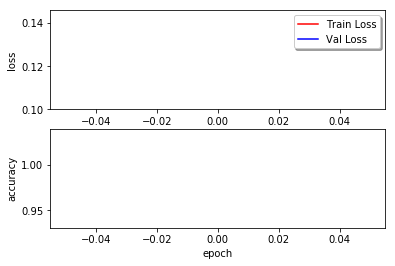

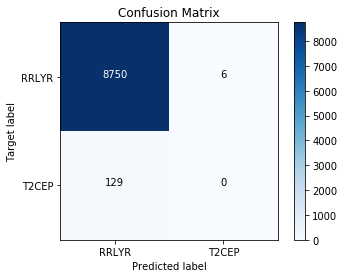

EPOCH: 2
TRAIN LOSS: 0.0785056026066395
VAL LOSS: 0.08180414056017576
VAL ACCURACY: 98.5 %
TIME: 90.1 s


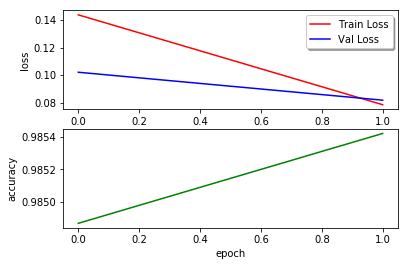

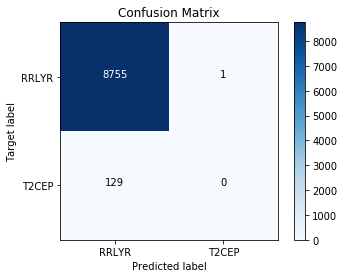

EPOCH: 3
TRAIN LOSS: 0.07050563790505353
VAL LOSS: 0.07514980978031686
VAL ACCURACY: 98.5 %
TIME: 88.9 s


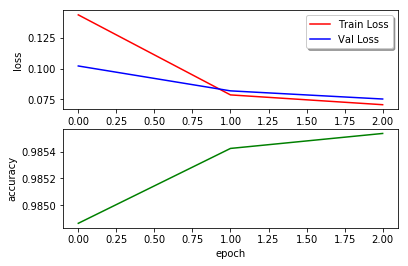

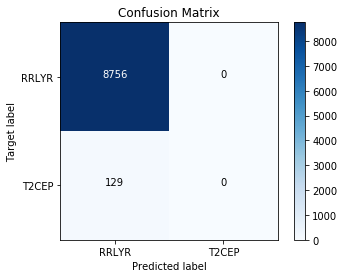

EPOCH: 4
TRAIN LOSS: 0.06612069430141891
VAL LOSS: 0.0714041426724561
VAL ACCURACY: 98.5 %
TIME: 87.9 s


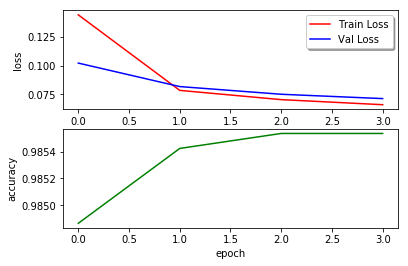

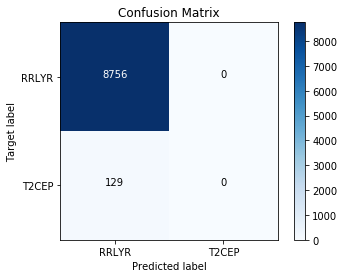

EPOCH: 5
TRAIN LOSS: 0.06360009613490603
VAL LOSS: 0.06944405506906769
VAL ACCURACY: 98.5 %
TIME: 88.8 s


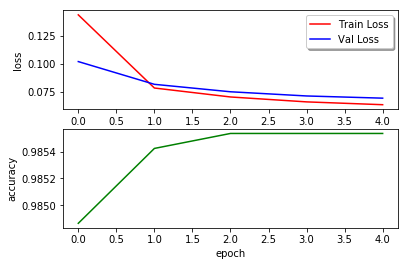

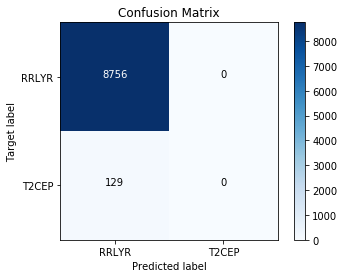

EPOCH: 6
TRAIN LOSS: 0.06099589495109393
VAL LOSS: 0.06778469433021811
VAL ACCURACY: 98.5 %
TIME: 87.7 s


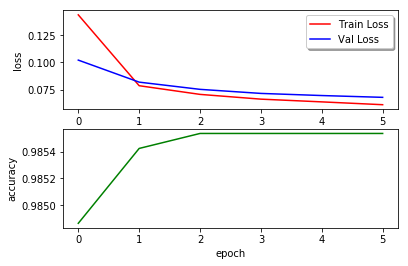

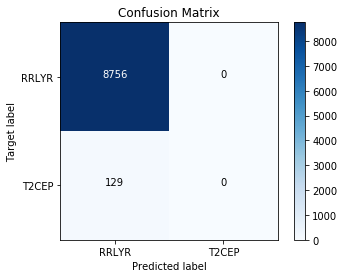

EPOCH: 7
TRAIN LOSS: 0.059035404902102656
VAL LOSS: 0.06533192848562965
VAL ACCURACY: 98.5 %
TIME: 90.8 s


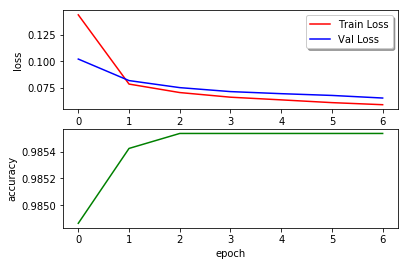

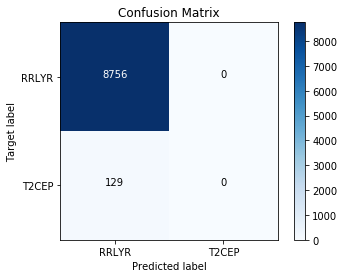

EPOCH: 8
TRAIN LOSS: 0.05699171065437062
VAL LOSS: 0.06204080108080141
VAL ACCURACY: 98.5 %
TIME: 87.4 s


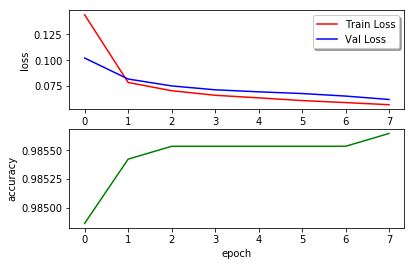

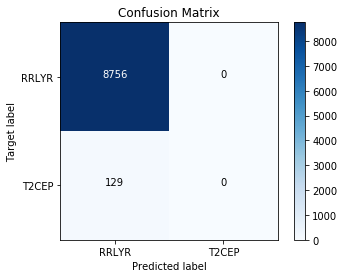

EPOCH: 9
TRAIN LOSS: 0.05570276108994026
VAL LOSS: 0.062386920595713456
VAL ACCURACY: 98.5 %
TIME: 88.6 s


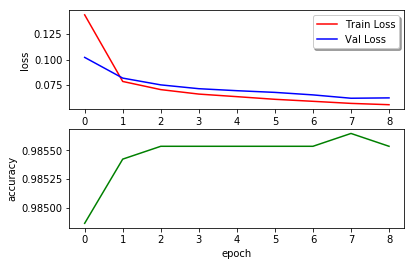

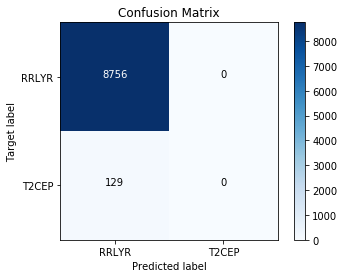

EPOCH: 10
TRAIN LOSS: 0.052178116091878064
VAL LOSS: 0.06007526682767735
VAL ACCURACY: 98.6 %
TIME: 87.4 s


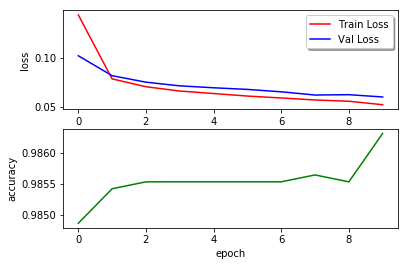

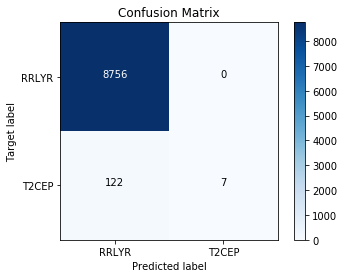

EPOCH: 11
TRAIN LOSS: 0.050740198428788526
VAL LOSS: 0.061304551789487495
VAL ACCURACY: 98.5 %
TIME: 90.3 s


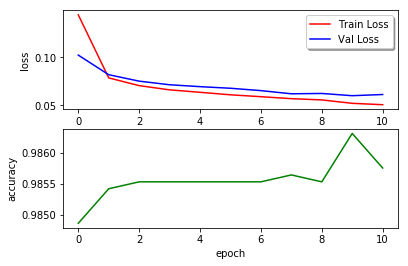

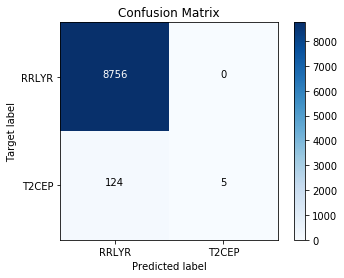

EPOCH: 12
TRAIN LOSS: 0.05169315810206449
VAL LOSS: 0.05980552766241731
VAL ACCURACY: 98.5 %
TIME: 90.1 s


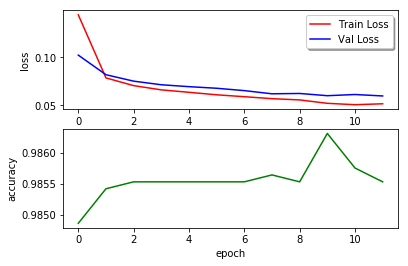

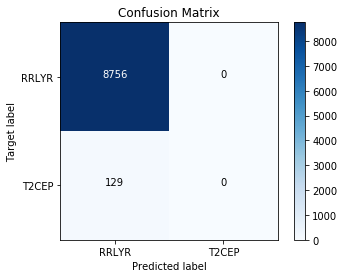

EPOCH: 13
TRAIN LOSS: 0.04873814572159127
VAL LOSS: 0.06245308890999893
VAL ACCURACY: 98.5 %
TIME: 88.6 s


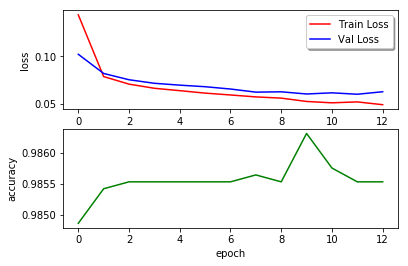

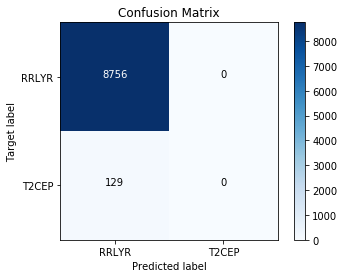

EPOCH: 14
TRAIN LOSS: 0.049538057883455076
VAL LOSS: 0.05794033630295016
VAL ACCURACY: 98.5 %
TIME: 89.8 s


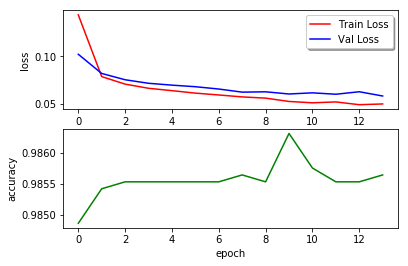

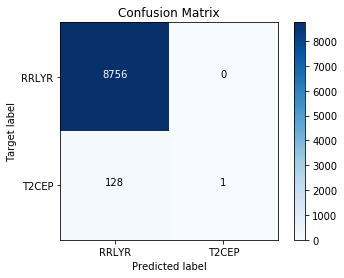

EPOCH: 15
TRAIN LOSS: 0.048241339150694805
VAL LOSS: 0.05887621771014389
VAL ACCURACY: 98.5 %
TIME: 90.6 s


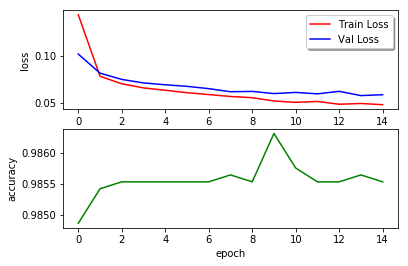

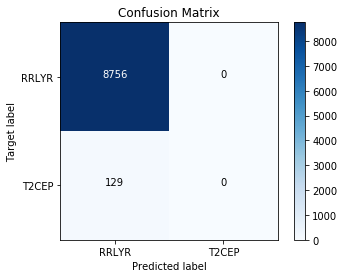

EPOCH: 16
TRAIN LOSS: 0.04487638963102552
VAL LOSS: 0.05691761341432709
VAL ACCURACY: 98.6 %
TIME: 87.1 s


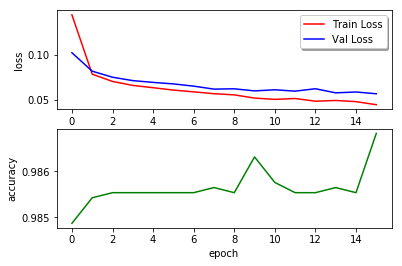

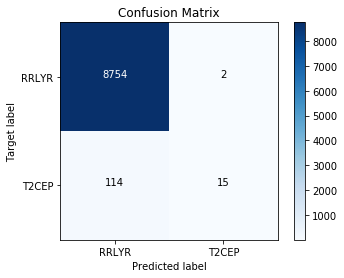

EPOCH: 17
TRAIN LOSS: 0.0445143064891014
VAL LOSS: 0.05558108477713459
VAL ACCURACY: 98.6 %
TIME: 90.3 s


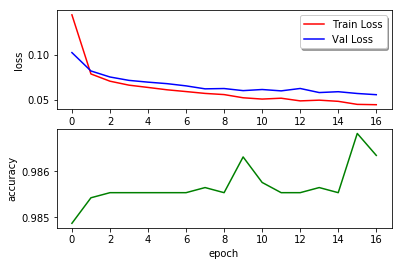

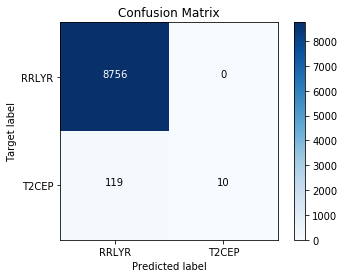

EPOCH: 18
TRAIN LOSS: 0.041566152018593656
VAL LOSS: 0.05903259119427161
VAL ACCURACY: 98.6 %
TIME: 89.5 s


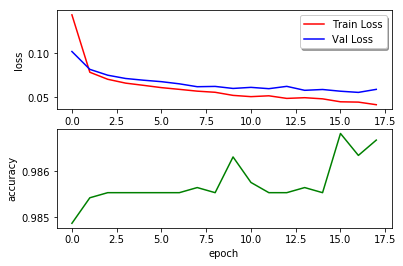

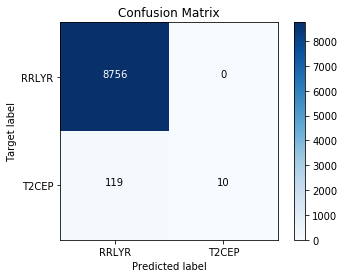

EPOCH: 19
TRAIN LOSS: 0.041283769257882776
VAL LOSS: 0.05506223627514162
VAL ACCURACY: 98.7 %
TIME: 89.3 s


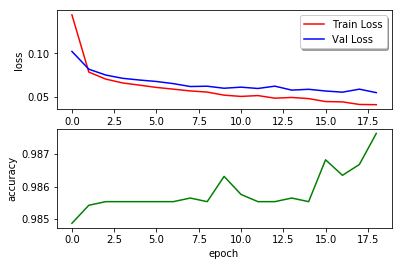

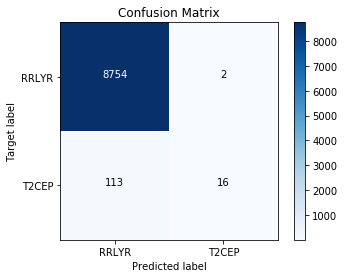

EPOCH: 20
TRAIN LOSS: 0.03959740212647001
VAL LOSS: 0.05553755331776916
VAL ACCURACY: 98.7 %
TIME: 90.9 s


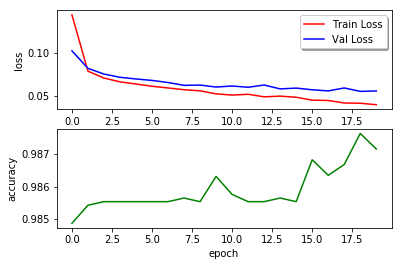

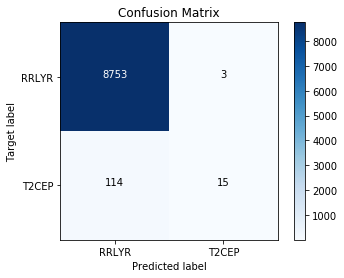

EPOCH: 21
TRAIN LOSS: 0.04001795669139662
VAL LOSS: 0.05529041360188324
VAL ACCURACY: 98.7 %
TIME: 87.7 s


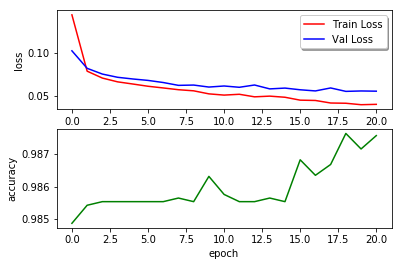

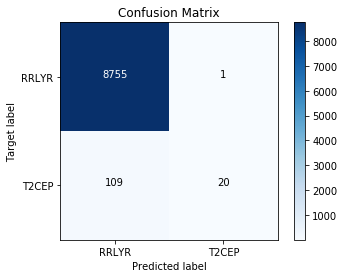

EPOCH: 22
TRAIN LOSS: 0.0388788862191179
VAL LOSS: 0.055081816655277296
VAL ACCURACY: 98.6 %
TIME: 87.1 s


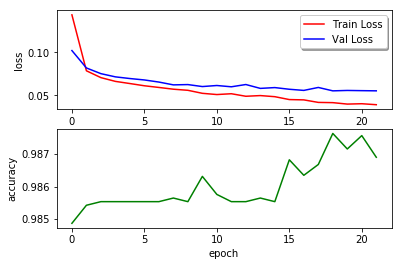

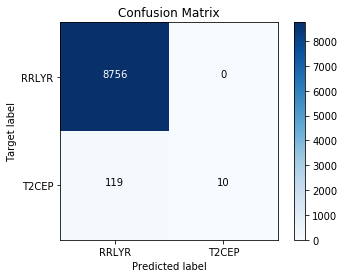

EPOCH: 23
TRAIN LOSS: 0.03587158223178981
VAL LOSS: 0.05243993514196407
VAL ACCURACY: 98.7 %
TIME: 90.6 s


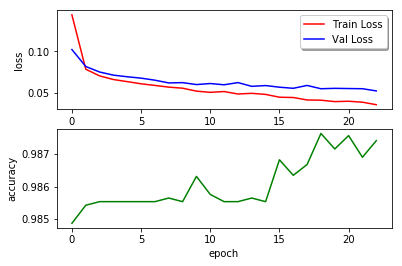

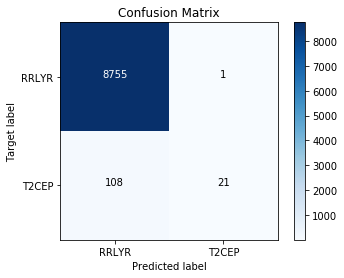

EPOCH: 24
TRAIN LOSS: 0.0353182514793616
VAL LOSS: 0.052355615475491085
VAL ACCURACY: 98.7 %
TIME: 88.9 s


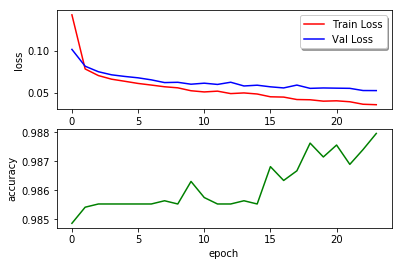

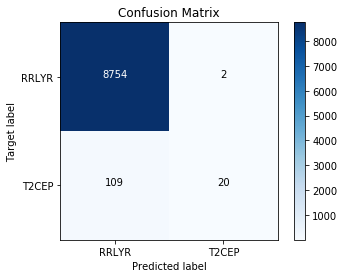

EPOCH: 25
TRAIN LOSS: 0.035702859095105295
VAL LOSS: 0.055188646539923614
VAL ACCURACY: 98.6 %
TIME: 88.9 s


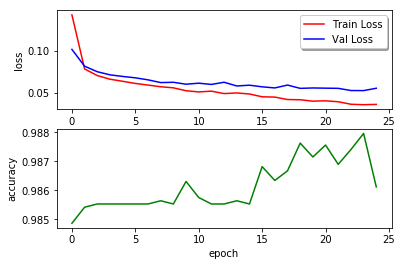

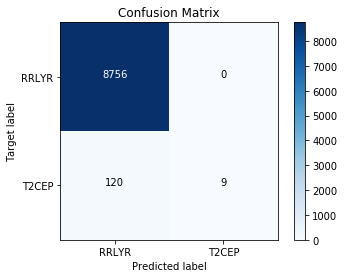

EPOCH: 26
TRAIN LOSS: 0.03287134212981187
VAL LOSS: 0.050211783831823856
VAL ACCURACY: 98.7 %
TIME: 88.7 s


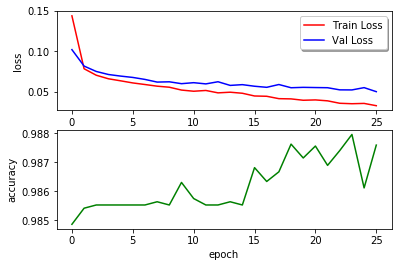

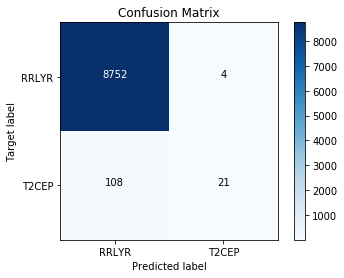

EPOCH: 27
TRAIN LOSS: 0.03427178134972207
VAL LOSS: 0.056769786520855986
VAL ACCURACY: 98.7 %
TIME: 90.4 s


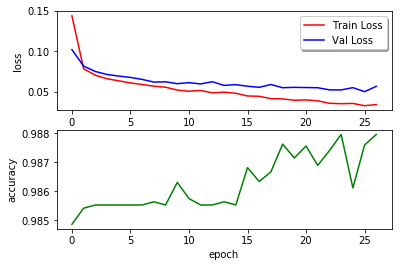

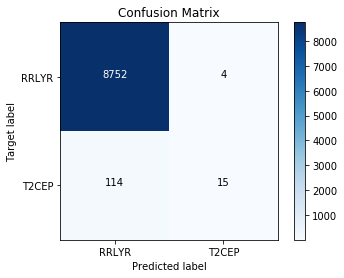

EPOCH: 28
TRAIN LOSS: 0.033097867677594574
VAL LOSS: 0.05246565348239447
VAL ACCURACY: 98.7 %
TIME: 88.9 s


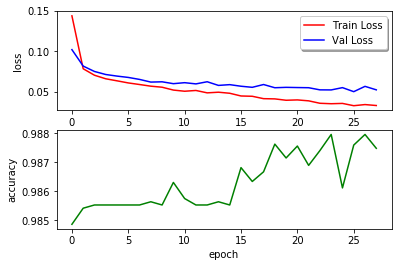

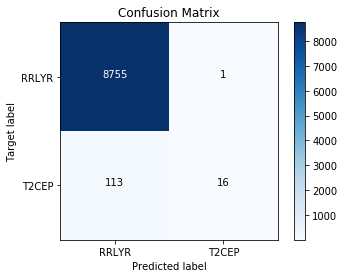

EPOCH: 29
TRAIN LOSS: 0.030554397778368183
VAL LOSS: 0.05281271847455597
VAL ACCURACY: 98.7 %
TIME: 89.8 s


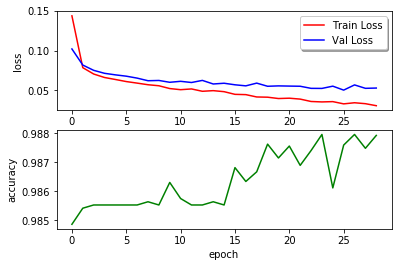

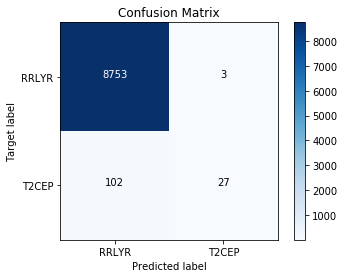

EPOCH: 30
TRAIN LOSS: 0.029825114327562647
VAL LOSS: 0.055560366978998355
VAL ACCURACY: 98.6 %
TIME: 90.3 s


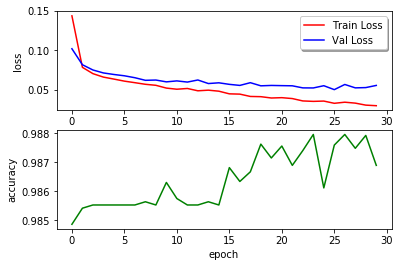

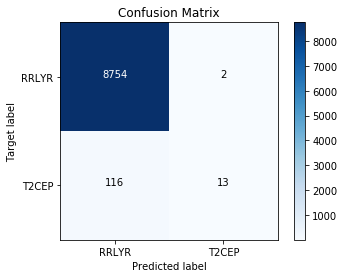

EPOCH: 31
TRAIN LOSS: 0.03292941648353659
VAL LOSS: 0.04987155372790835
VAL ACCURACY: 98.7 %
TIME: 88.8 s


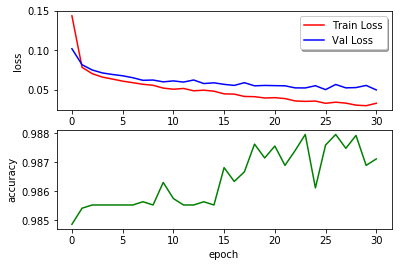

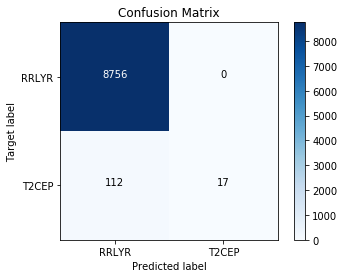

EPOCH: 32
TRAIN LOSS: 0.03301971406141562
VAL LOSS: 0.05411259866342591
VAL ACCURACY: 98.7 %
TIME: 87.9 s


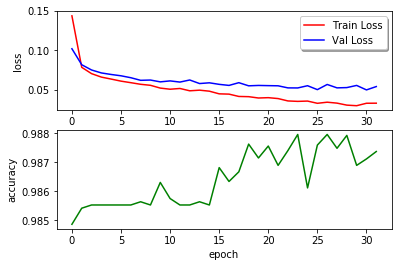

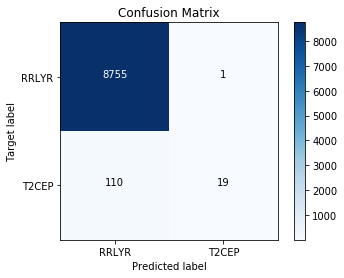

EPOCH: 33
TRAIN LOSS: 0.031103211944435986
VAL LOSS: 0.04886243844612269
VAL ACCURACY: 98.9 %
TIME: 89.9 s


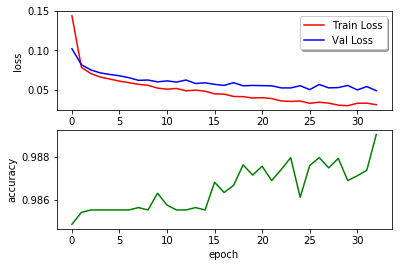

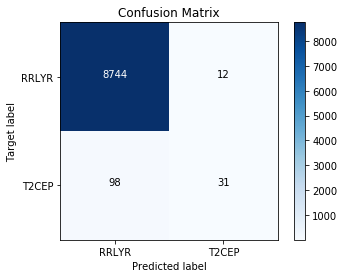

EPOCH: 34
TRAIN LOSS: 0.03202690193294509
VAL LOSS: 0.04968259045758772
VAL ACCURACY: 98.7 %
TIME: 90.0 s


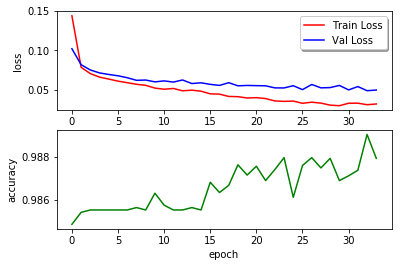

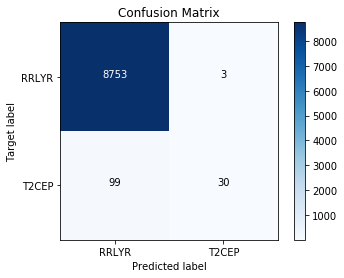

EPOCH: 35
TRAIN LOSS: 0.03103270524725223
VAL LOSS: 0.05217223134477094
VAL ACCURACY: 98.8 %
TIME: 88.3 s


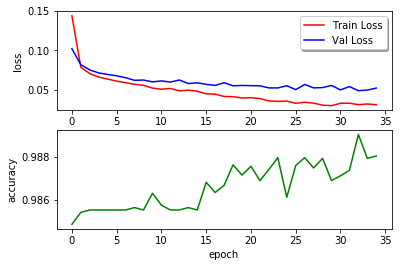

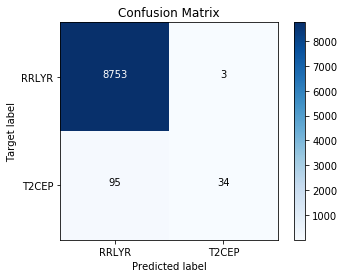

EPOCH: 36
TRAIN LOSS: 0.032493658520134666
VAL LOSS: 0.05493613987862599
VAL ACCURACY: 98.6 %
TIME: 89.0 s


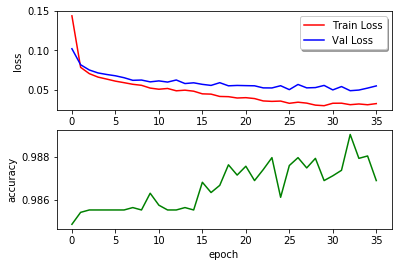

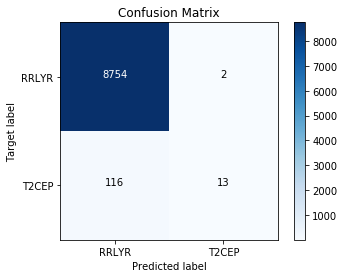

EPOCH: 37
TRAIN LOSS: 0.03179170270340844
VAL LOSS: 0.04982979545830409
VAL ACCURACY: 98.8 %
TIME: 87.2 s


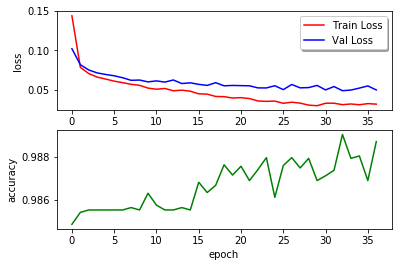

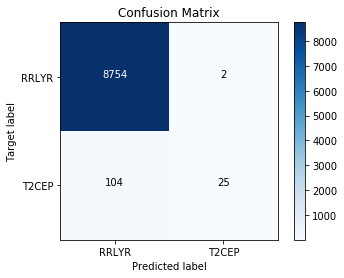

EPOCH: 38
TRAIN LOSS: 0.031171490579055418
VAL LOSS: 0.04893538461691957
VAL ACCURACY: 98.8 %
TIME: 87.8 s


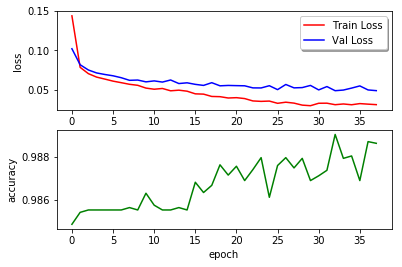

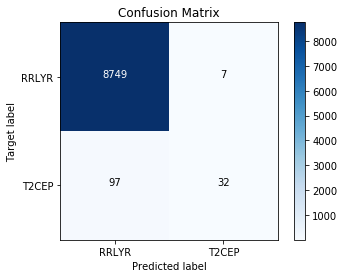

EPOCH: 39
TRAIN LOSS: 0.03163185329271504
VAL LOSS: 0.05012611615988486
VAL ACCURACY: 98.8 %
TIME: 89.2 s


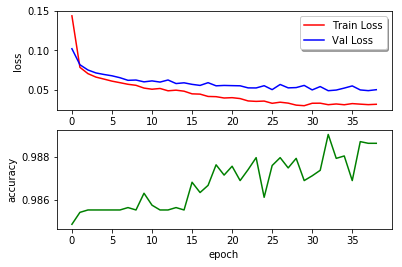

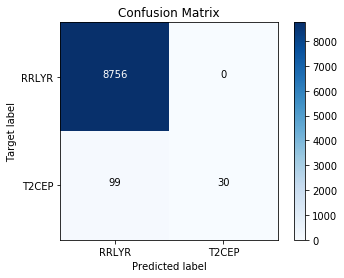

EPOCH: 40
TRAIN LOSS: 0.02761732694505527
VAL LOSS: 0.05115771329857466
VAL ACCURACY: 98.7 %
TIME: 91.3 s


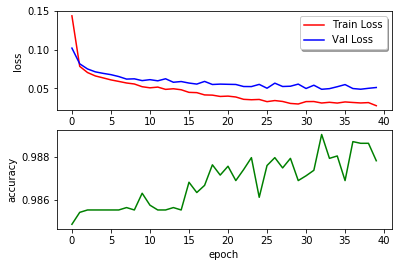

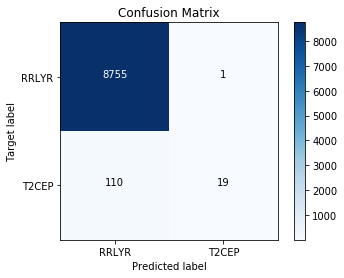

EPOCH: 41
TRAIN LOSS: 0.02712716537097444
VAL LOSS: 0.051059721547787956
VAL ACCURACY: 98.8 %
TIME: 88.1 s


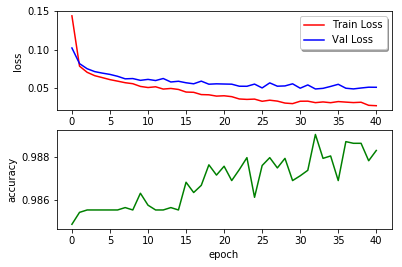

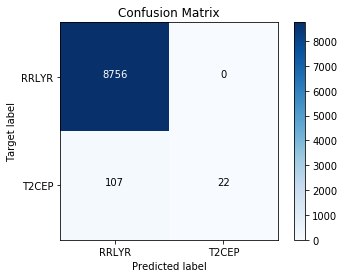

EPOCH: 42
TRAIN LOSS: 0.025228453910660167
VAL LOSS: 0.04964430405531603
VAL ACCURACY: 98.8 %
TIME: 87.8 s


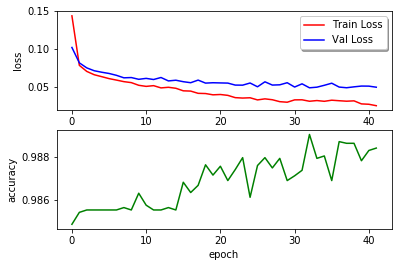

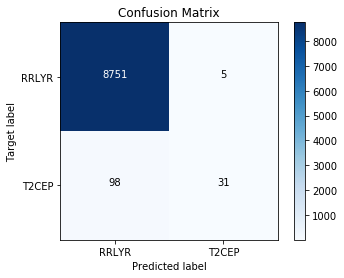

EPOCH: 43
TRAIN LOSS: 0.02463773351718494
VAL LOSS: 0.050796445267490026
VAL ACCURACY: 98.8 %
TIME: 88.2 s


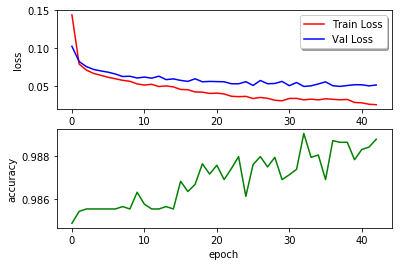

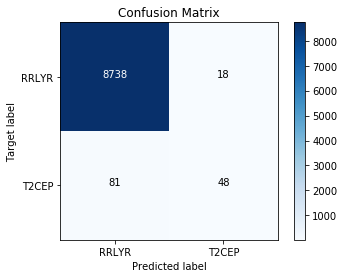

EPOCH: 44
TRAIN LOSS: 0.028920613321753004
VAL LOSS: 0.049703202438404634
VAL ACCURACY: 98.8 %
TIME: 66.3 s


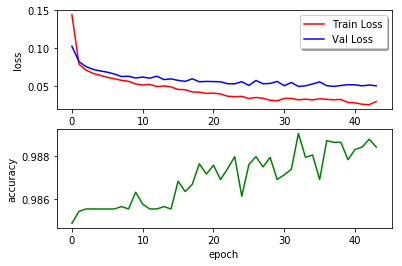

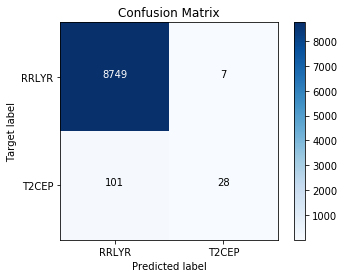

EPOCH: 45
TRAIN LOSS: 0.02613284181026681
VAL LOSS: 0.05350790060336421
VAL ACCURACY: 98.8 %
TIME: 66.3 s


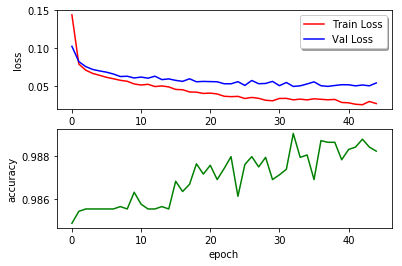

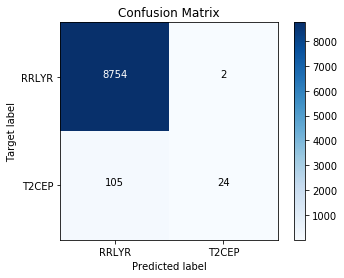

EPOCH: 46
TRAIN LOSS: 0.029861195127139365
VAL LOSS: 0.05210451542946954
VAL ACCURACY: 98.7 %
TIME: 66.1 s


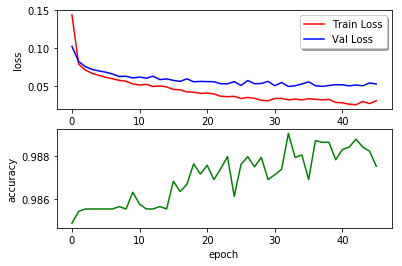

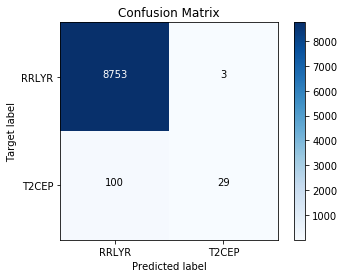

EPOCH: 47
TRAIN LOSS: 0.027248480158933438
VAL LOSS: 0.04992312490972983
VAL ACCURACY: 98.8 %
TIME: 66.2 s


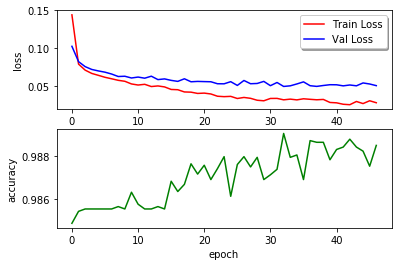

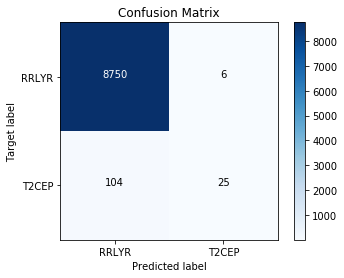

EPOCH: 48
TRAIN LOSS: 0.026147792166542467
VAL LOSS: 0.04758214113417514
VAL ACCURACY: 98.9 %
TIME: 66.1 s


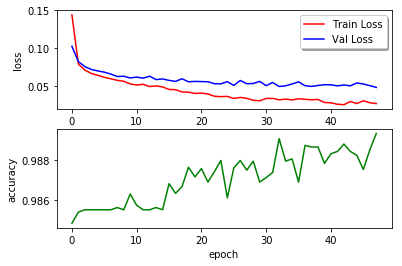

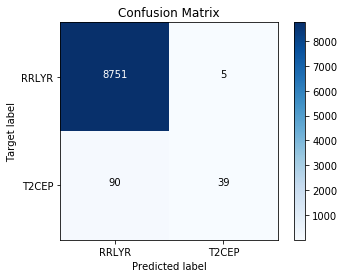

EPOCH: 49
TRAIN LOSS: 0.027278012527345318
VAL LOSS: 0.049764287720404934
VAL ACCURACY: 98.8 %
TIME: 66.0 s


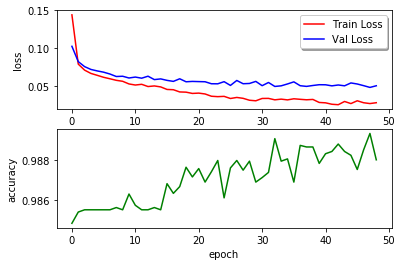

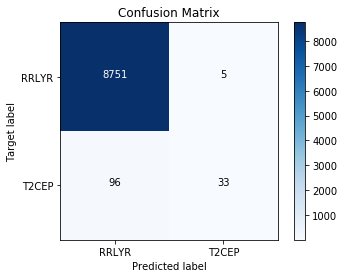

EPOCH: 50
TRAIN LOSS: 0.023537077365813425
VAL LOSS: 0.05125644858852136
VAL ACCURACY: 98.8 %
TIME: 66.0 s


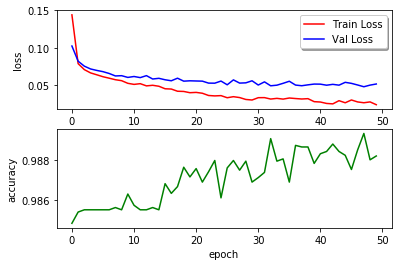

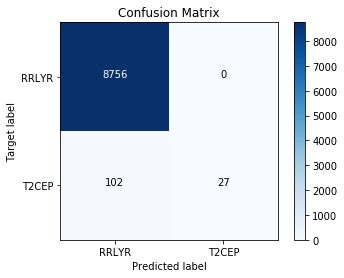

EPOCH: 51
TRAIN LOSS: 0.02291757177194163
VAL LOSS: 0.04748935348490001
VAL ACCURACY: 98.9 %
TIME: 66.2 s


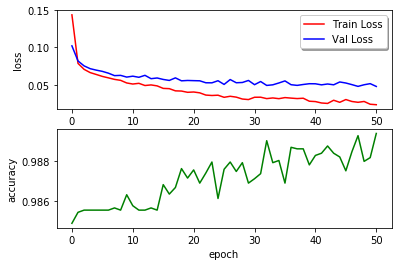

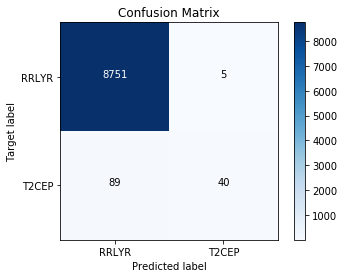

EPOCH: 52
TRAIN LOSS: 0.026571746462647365
VAL LOSS: 0.0512166554644154
VAL ACCURACY: 98.7 %
TIME: 66.2 s


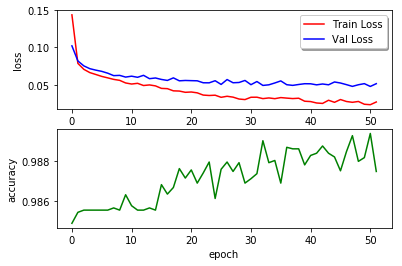

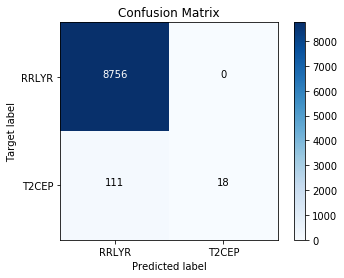

EPOCH: 53
TRAIN LOSS: 0.026698508925804738
VAL LOSS: 0.051423971075828426
VAL ACCURACY: 98.6 %
TIME: 66.1 s


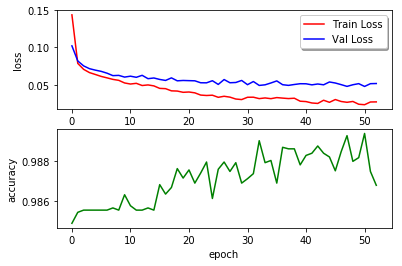

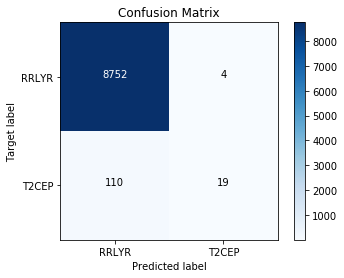

EPOCH: 54
TRAIN LOSS: 0.024517285536615935
VAL LOSS: 0.053237504045617036
VAL ACCURACY: 98.6 %
TIME: 66.1 s


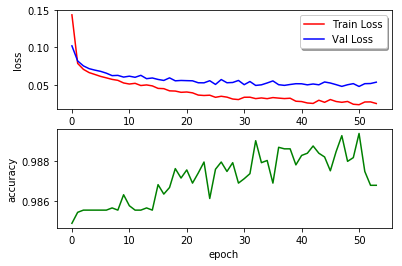

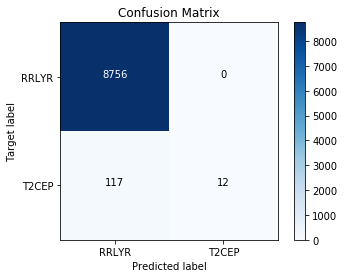

EPOCH: 55
TRAIN LOSS: 0.026214170294880396
VAL LOSS: 0.051513353857789955
VAL ACCURACY: 98.7 %
TIME: 66.2 s


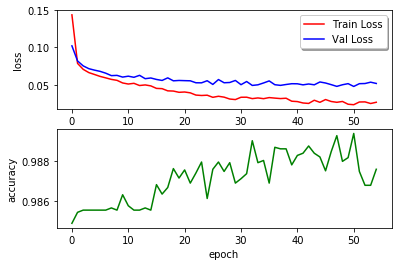

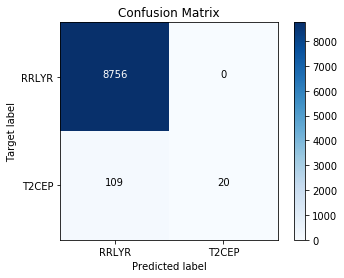

EPOCH: 56
TRAIN LOSS: 0.024612509303606894
VAL LOSS: 0.05029829121222392
VAL ACCURACY: 98.7 %
TIME: 66.1 s


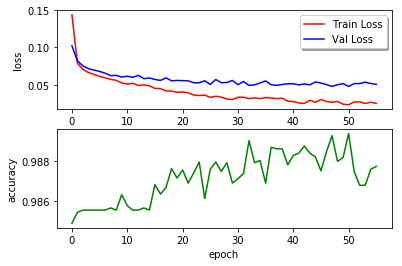

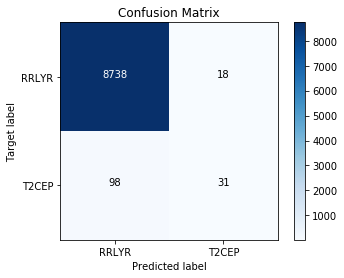

EPOCH: 57
TRAIN LOSS: 0.02303663177697548
VAL LOSS: 0.05046334707326911
VAL ACCURACY: 98.9 %
TIME: 66.1 s


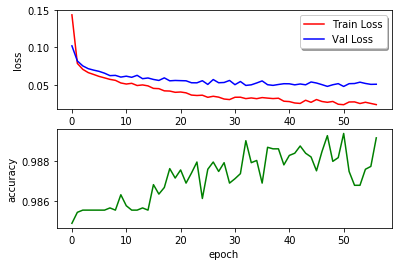

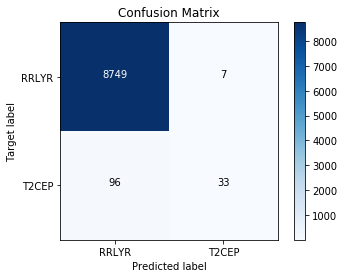

EPOCH: 58
TRAIN LOSS: 0.02262146968458257
VAL LOSS: 0.060105092300182066
VAL ACCURACY: 98.7 %
TIME: 66.2 s


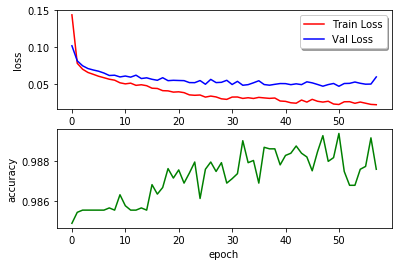

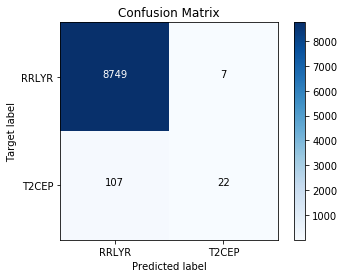

EPOCH: 59
TRAIN LOSS: 0.022446426738238802
VAL LOSS: 0.05873019971562891
VAL ACCURACY: 98.7 %
TIME: 66.1 s


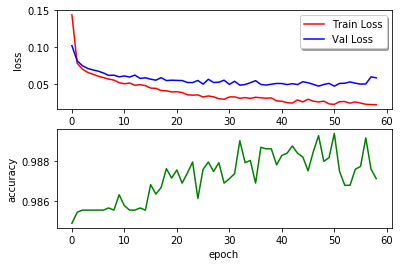

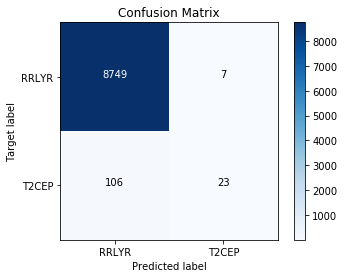

EPOCH: 60
TRAIN LOSS: 0.023280421536481886
VAL LOSS: 0.050546185272171626
VAL ACCURACY: 98.8 %
TIME: 66.1 s


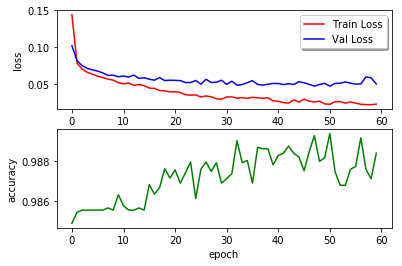

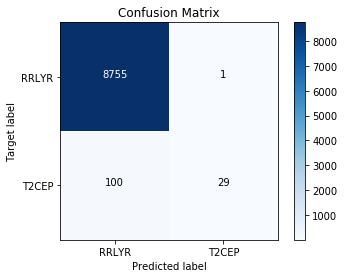

EPOCH: 61
TRAIN LOSS: 0.025632438365474672
VAL LOSS: 0.06023954654106754
VAL ACCURACY: 98.8 %
TIME: 66.1 s


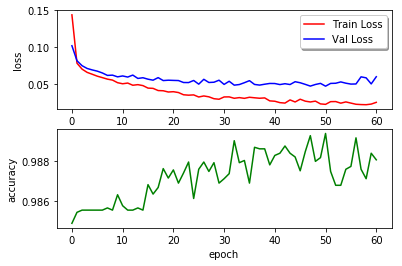

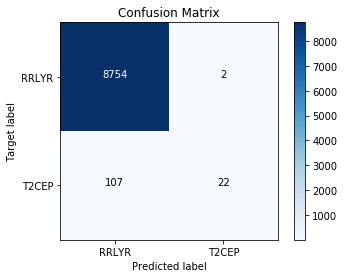

EPOCH: 62
TRAIN LOSS: 0.026162325935442293
VAL LOSS: 0.057930583357873724
VAL ACCURACY: 98.5 %
TIME: 66.1 s


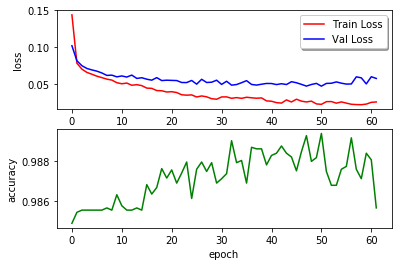

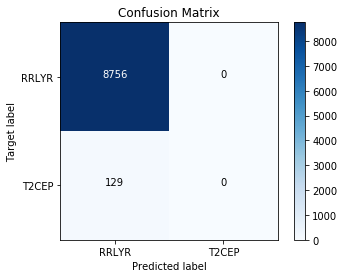

EPOCH: 63
TRAIN LOSS: 0.026464227416783382
VAL LOSS: 0.06527002650311027
VAL ACCURACY: 98.5 %
TIME: 66.2 s


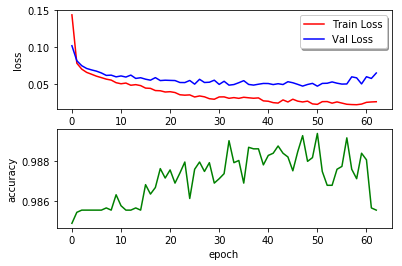

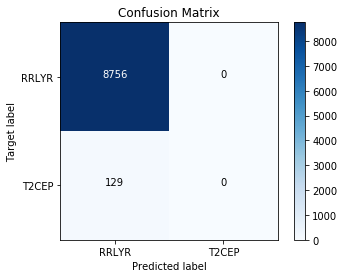

EPOCH: 64
TRAIN LOSS: 0.027425885142450368
VAL LOSS: 0.05192100536742014
VAL ACCURACY: 98.7 %
TIME: 66.2 s


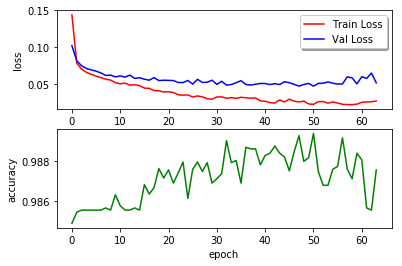

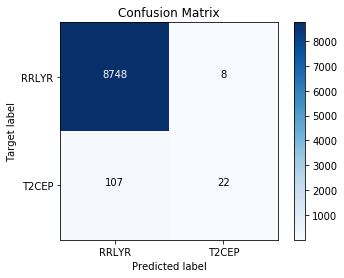

EPOCH: 65
TRAIN LOSS: 0.022289498137249977
VAL LOSS: 0.06049899962898156
VAL ACCURACY: 98.7 %
TIME: 66.1 s


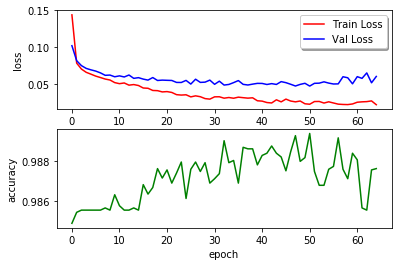

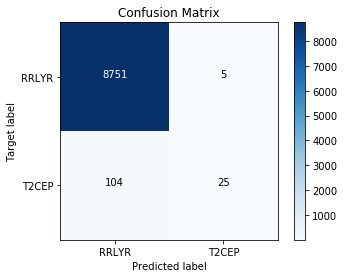

EPOCH: 66
TRAIN LOSS: 0.023799744390649094
VAL LOSS: 0.05576302457195115
VAL ACCURACY: 98.7 %
TIME: 66.2 s


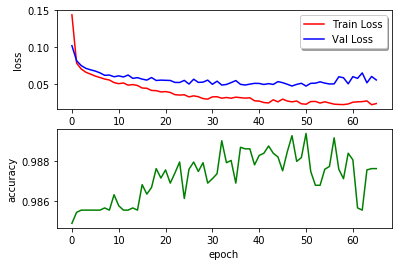

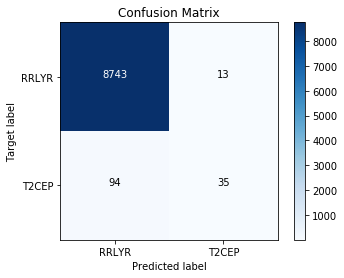

EPOCH: 67
TRAIN LOSS: 0.0248439569017942
VAL LOSS: 0.05805826072228734
VAL ACCURACY: 98.6 %
TIME: 66.2 s


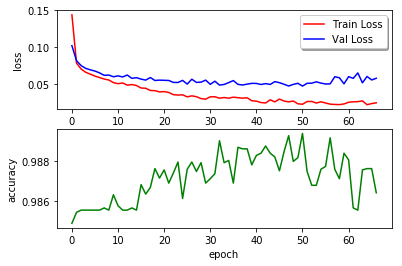

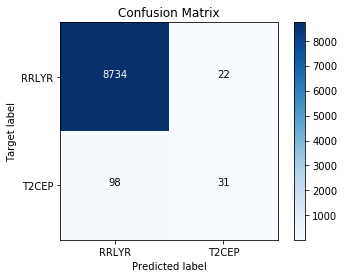

EPOCH: 68
TRAIN LOSS: 0.022521371701836483
VAL LOSS: 0.06329761934226719
VAL ACCURACY: 98.6 %
TIME: 66.2 s


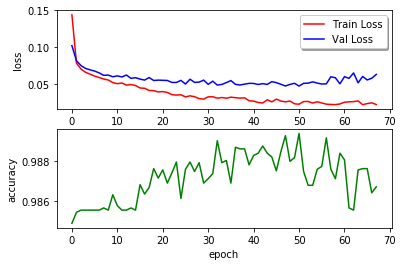

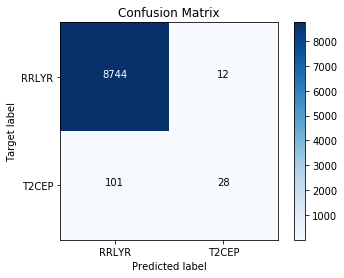

EPOCH: 69
TRAIN LOSS: 0.02225027708506299
VAL LOSS: 0.06027000516069519
VAL ACCURACY: 98.7 %
TIME: 66.3 s


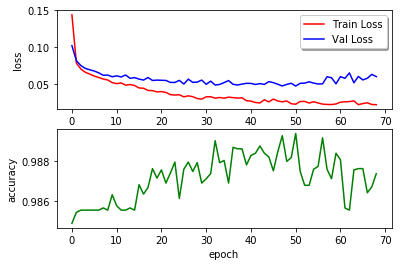

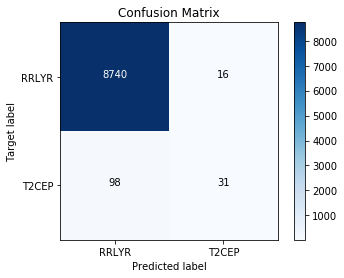

EPOCH: 70
TRAIN LOSS: 0.021976691010531325
VAL LOSS: 0.06515599596447676
VAL ACCURACY: 98.7 %
TIME: 66.2 s


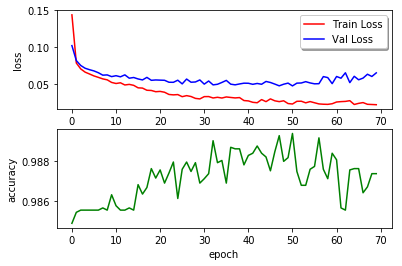

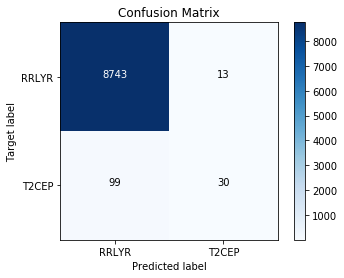

EPOCH: 71
TRAIN LOSS: 0.023243121909878695
VAL LOSS: 0.06922137602924323
VAL ACCURACY: 98.5 %
TIME: 66.2 s


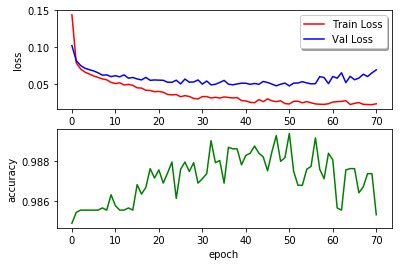

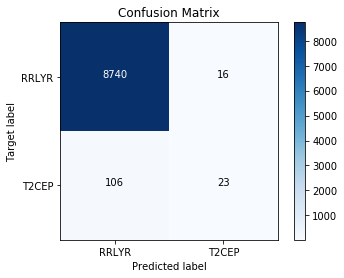

EPOCH: 72
TRAIN LOSS: 0.02556784822305342
VAL LOSS: 0.07708102304387182
VAL ACCURACY: 98.7 %
TIME: 66.1 s


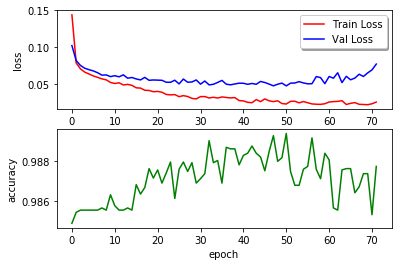

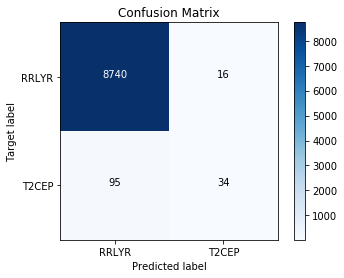

EPOCH: 73
TRAIN LOSS: 0.02147343039421379
VAL LOSS: 0.06613563161297989
VAL ACCURACY: 98.6 %
TIME: 66.2 s


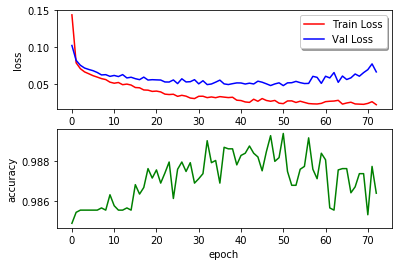

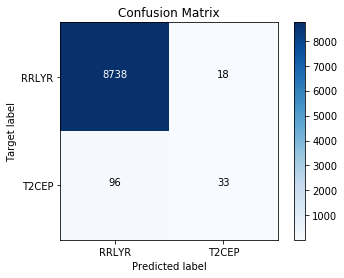

EPOCH: 74
TRAIN LOSS: 0.020348213770265838
VAL LOSS: 0.06808416838091343
VAL ACCURACY: 98.7 %
TIME: 66.2 s


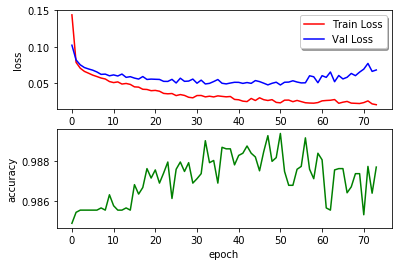

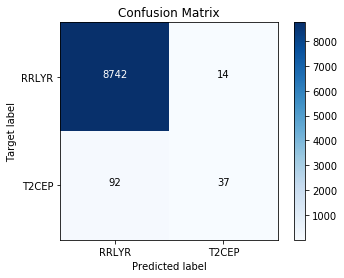

EPOCH: 75
TRAIN LOSS: 0.020747750950815883
VAL LOSS: 0.07643358830141586
VAL ACCURACY: 98.7 %
TIME: 66.2 s


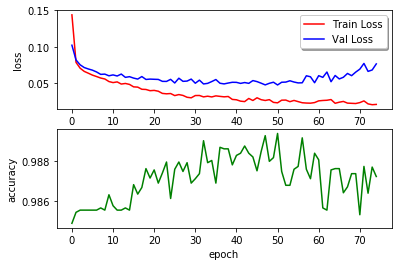

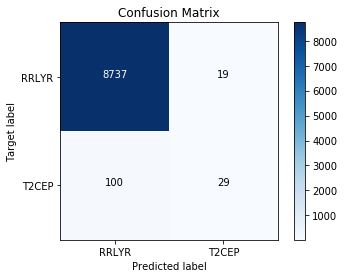

EPOCH: 76
TRAIN LOSS: 0.020145113639896836
VAL LOSS: 0.0777298167170162
VAL ACCURACY: 98.4 %
TIME: 66.3 s


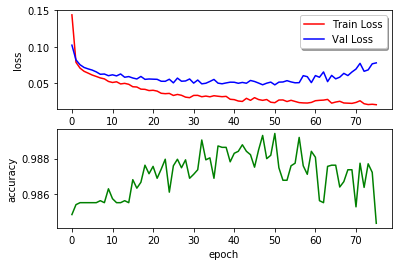

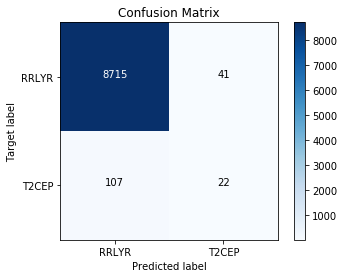

EPOCH: 77
TRAIN LOSS: 0.025518802578091093
VAL LOSS: 0.06347831682136346
VAL ACCURACY: 98.6 %
TIME: 66.3 s


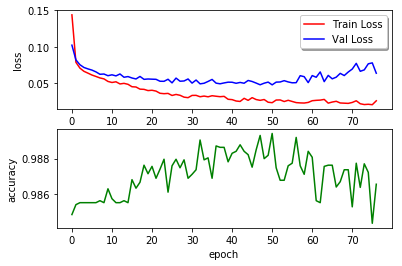

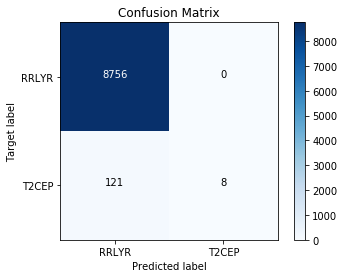

EPOCH: 78
TRAIN LOSS: 0.026585822663580585
VAL LOSS: 0.07548277433699097
VAL ACCURACY: 98.5 %
TIME: 66.2 s


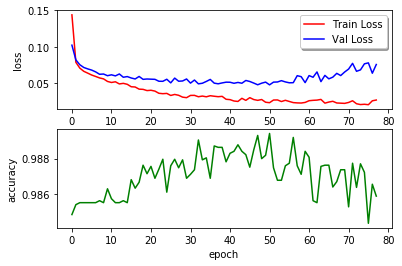

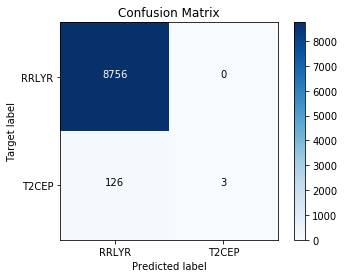

EPOCH: 79
TRAIN LOSS: 0.02444680529797553
VAL LOSS: 0.07225493894779274
VAL ACCURACY: 98.7 %
TIME: 66.3 s


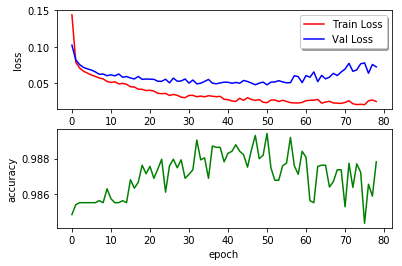

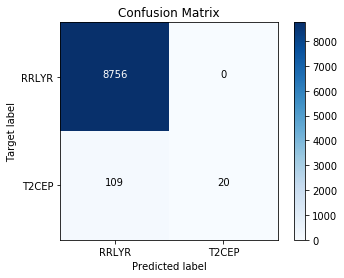

EPOCH: 80
TRAIN LOSS: 0.02286552981888547
VAL LOSS: 0.07517170412064215
VAL ACCURACY: 98.7 %
TIME: 66.2 s


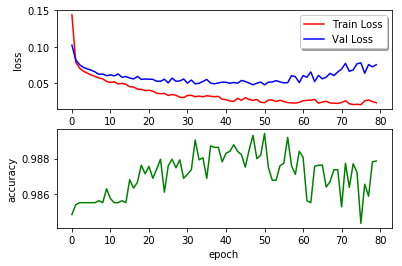

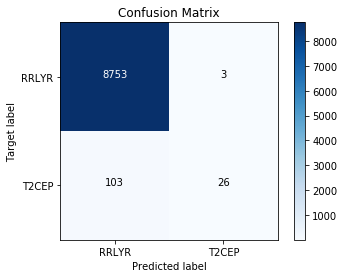

EPOCH: 81
TRAIN LOSS: 0.027066073222118833
VAL LOSS: 0.06976173474479248
VAL ACCURACY: 98.6 %
TIME: 66.4 s


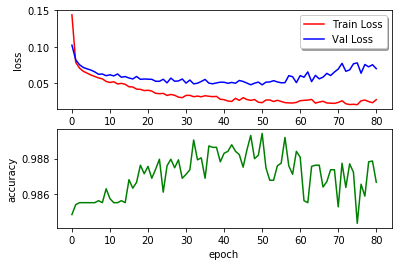

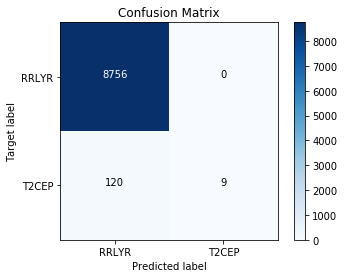

EPOCH: 82
TRAIN LOSS: 0.02955228815941712
VAL LOSS: 0.07427563743411265
VAL ACCURACY: 98.8 %
TIME: 66.4 s


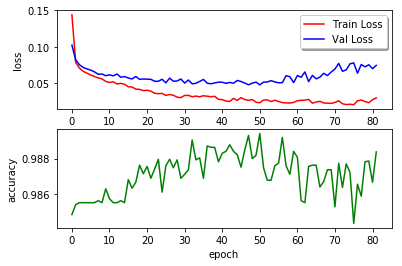

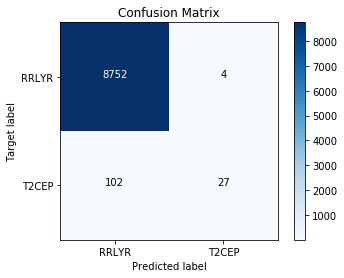

EPOCH: 83
TRAIN LOSS: 0.025251574092911802
VAL LOSS: 0.09218803431131051
VAL ACCURACY: 98.7 %
TIME: 66.3 s


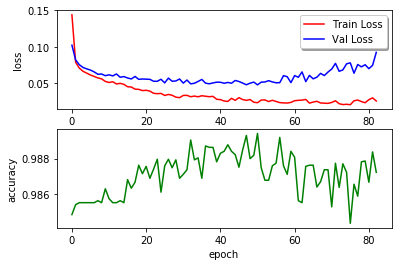

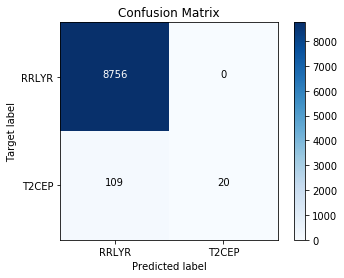

EPOCH: 84
TRAIN LOSS: 0.023353163334964764
VAL LOSS: 0.08482576399465112
VAL ACCURACY: 98.8 %
TIME: 66.3 s


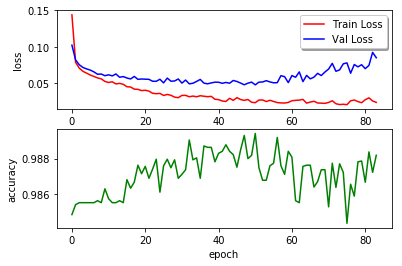

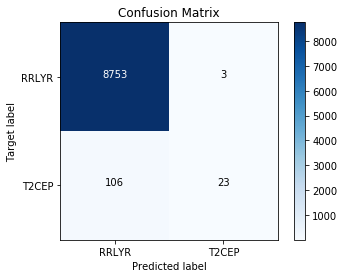

EPOCH: 85
TRAIN LOSS: 0.028951193587549925
VAL LOSS: 0.08854622577894876
VAL ACCURACY: 98.7 %
TIME: 66.6 s


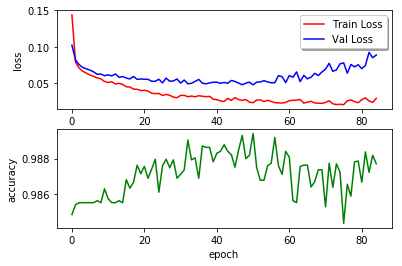

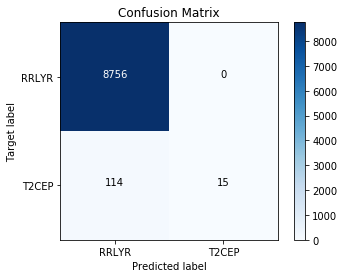

EPOCH: 86
TRAIN LOSS: 0.02592717105403383
VAL LOSS: 0.06658761325607494
VAL ACCURACY: 98.8 %
TIME: 66.2 s


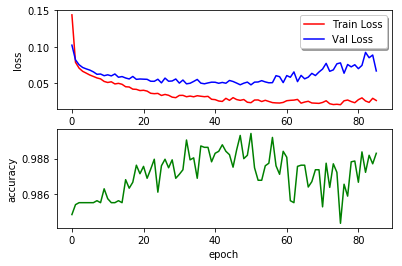

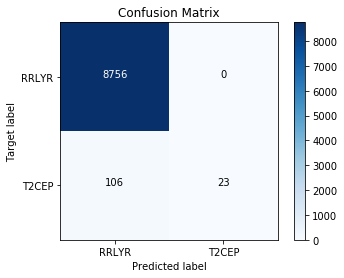

EPOCH: 87
TRAIN LOSS: 0.02117050309698345
VAL LOSS: 0.09043161879374481
VAL ACCURACY: 98.7 %
TIME: 66.3 s


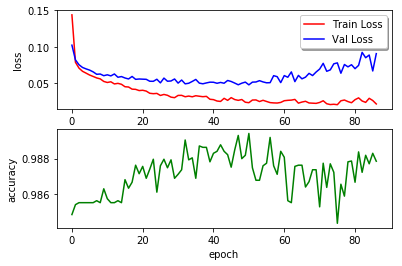

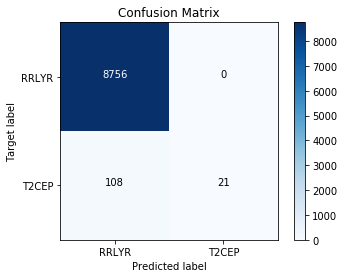

EPOCH: 88
TRAIN LOSS: 0.023339846646546376
VAL LOSS: 0.0576265700676972
VAL ACCURACY: 98.8 %
TIME: 66.2 s


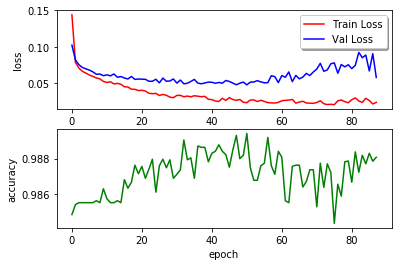

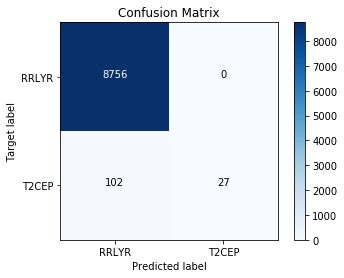

EPOCH: 89
TRAIN LOSS: 0.022770964922827406
VAL LOSS: 0.07604000343911915
VAL ACCURACY: 98.8 %
TIME: 66.3 s


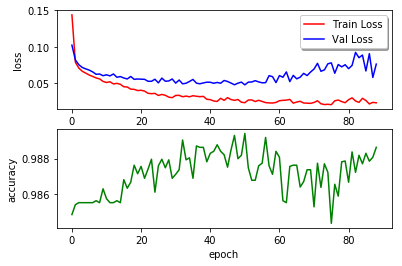

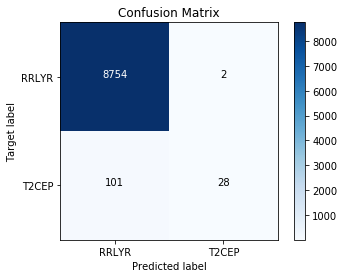

EPOCH: 90
TRAIN LOSS: 0.024704678573573544
VAL LOSS: 0.06778723979833758
VAL ACCURACY: 98.8 %
TIME: 66.3 s


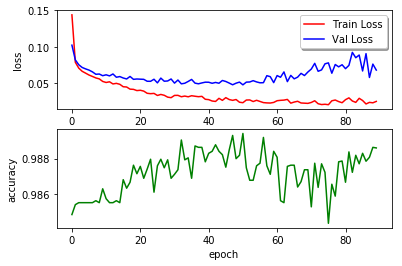

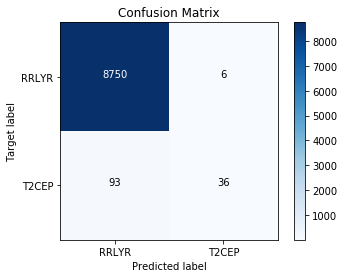

EPOCH: 91
TRAIN LOSS: 0.021708000253532565
VAL LOSS: 0.08382663016999599
VAL ACCURACY: 98.8 %
TIME: 66.3 s


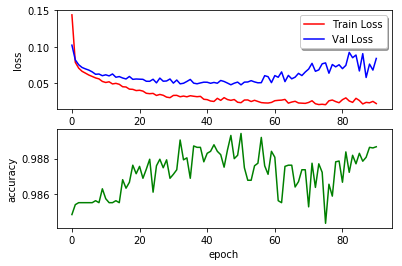

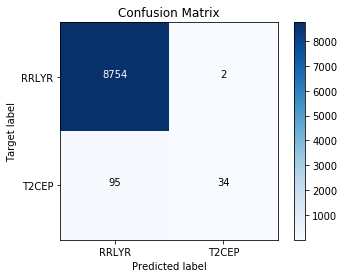

EPOCH: 92
TRAIN LOSS: 0.02052511968585551
VAL LOSS: 0.07801701716747426
VAL ACCURACY: 98.8 %
TIME: 66.1 s


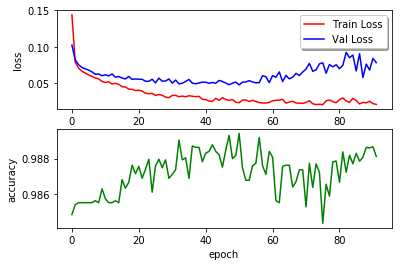

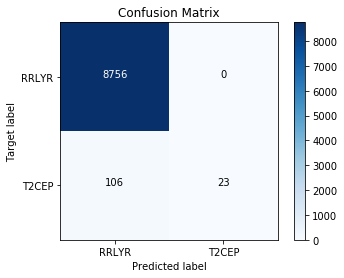

EPOCH: 93
TRAIN LOSS: 0.02362440040238207
VAL LOSS: 0.09305743307791103
VAL ACCURACY: 98.7 %
TIME: 66.3 s


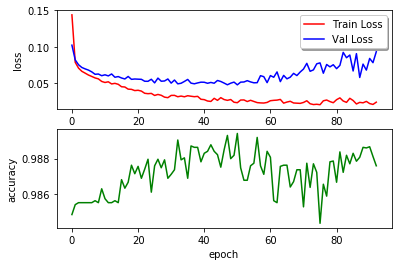

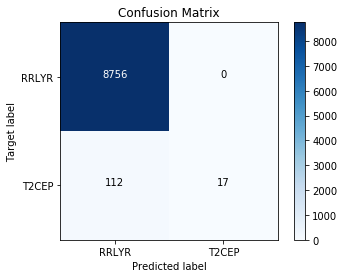

EPOCH: 94
TRAIN LOSS: 0.021086970981872347
VAL LOSS: 0.06695032763390676
VAL ACCURACY: 98.9 %
TIME: 66.2 s


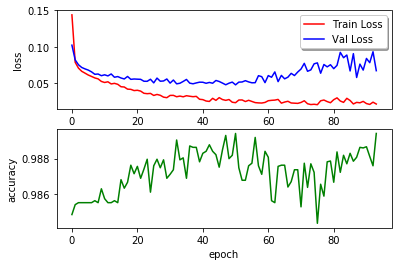

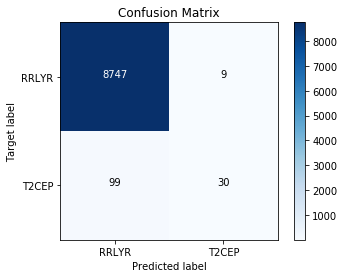

EPOCH: 95
TRAIN LOSS: 0.019468456152879936
VAL LOSS: 0.07151261604252648
VAL ACCURACY: 98.7 %
TIME: 66.1 s


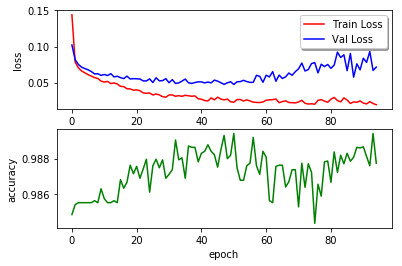

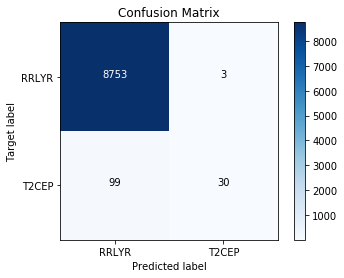

EPOCH: 96
TRAIN LOSS: 0.020252944019930445
VAL LOSS: 0.07053721663064269
VAL ACCURACY: 98.7 %
TIME: 66.4 s


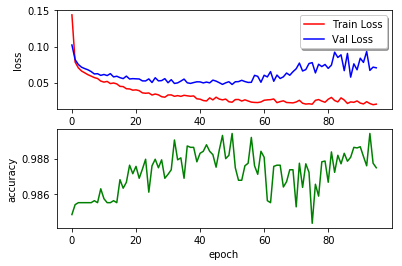

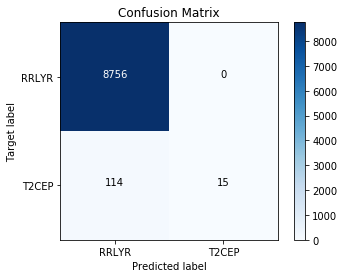

EPOCH: 97
TRAIN LOSS: 0.021114709125443026
VAL LOSS: 0.07585035128076957
VAL ACCURACY: 98.8 %
TIME: 66.3 s


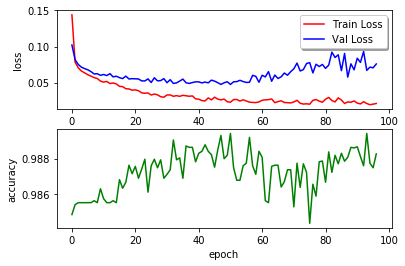

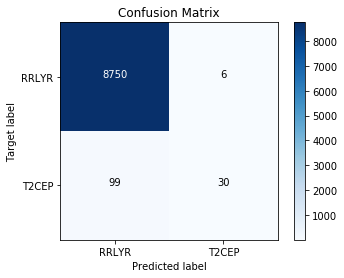

EPOCH: 98
TRAIN LOSS: 0.019519635772394857
VAL LOSS: 0.07470335951721713
VAL ACCURACY: 98.8 %
TIME: 66.3 s


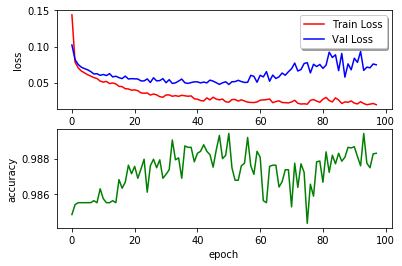

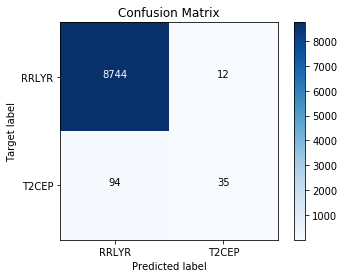

EPOCH: 99
TRAIN LOSS: 0.020055031882966222
VAL LOSS: 0.07494311436079605
VAL ACCURACY: 98.8 %
TIME: 66.3 s


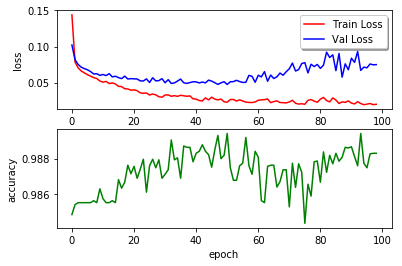

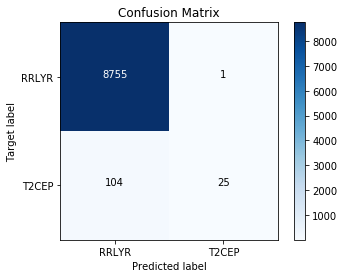

BEST VAL ACCURACY: 98.9 % EPOCH: 51
Final results:
  test loss:			0.077403
  test accuracy:		98.77 %
TRAINING DONE!


In [32]:
import time
import sklearn
import numpy 
import matplotlib.pyplot as plt
import numpy as np
###################### TRAINING #########################
print ("START TRAINING...")
train_loss = []
val_loss = []
val_accuracy = []
for epoch in range(1,100):
 
    #start timer
    start = time.time()
    
    #reset confusion matrix
    clearConfusionMatrix()
 
    #iterate over train split batches and calculate mean loss for epoch
    t_l = []
    for image_batch, target_batch in getNextImageBatch():
 
        #calling the training functions returns the current loss
        l = train_net(image_batch, target_batch)
        t_l.append(l)
 
    #we validate our net every epoch and pass our validation split through as well
    v_l = []
    v_a = []
    for image_batch, target_batch in getNextImageBatch(VAL):
  
        #calling the test function returns the net output, loss and accuracy
        prediction_batch, l, a = test_net(image_batch, target_batch)
        v_l.append(l)
        v_a.append(a)
         
        #save predicions and targets for confusion matrix
        
        updateConfusionMatrix(target_batch,prediction_batch)
    
    #mlxtend confusion matrix
    #cm=confusion_matrix(target_batch,prediction_batch)
    #    fig,ax=plot_confusion_matrix(conf_mat=cm)
      #  plt.show()
        
        #pandas_ml confusion matrix
        #confusion_matrix1 = ConfusionMatrix(target_batch,prediction_batch)
        #print("Confusion matrix:\n%s" % confusion_matrix1)
        
    #stop timer
    end = time.time()
 
    #calculate stats for epoch
    train_loss.append(np.mean(t_l))
    val_loss.append(np.mean(v_l))
    val_accuracy.append(np.mean(v_a))
 
    #print stats for epoch
    print ("EPOCH:", epoch,)
    print ("TRAIN LOSS:", train_loss[-1],)
    print ("VAL LOSS:", val_loss[-1],)
    print ("VAL ACCURACY:", (int(val_accuracy[-1] * 1000) / 10.0), "%",)
    print ("TIME:", (int((end - start) * 10) / 10.0), "s")
 
    #show chart
    showChart(epoch, train_loss, val_loss, val_accuracy)
    
    #show confusion matrix
    showConfusionMatrix()

    #show best accuracy and epoch
print ("BEST VAL ACCURACY:", (int(max(val_accuracy) * 1000) / 10.0), "%", "EPOCH:", val_accuracy.index(max(val_accuracy)) + 1)

#####TESTING DATA#######
test_err = 0
test_acc = 0
test_batches = 0
for image_batch, target_batch in getNextImageBatch1():
    test_batch, err, acc = test_net(image_batch, target_batch)
    test_err += err
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))
print ("TRAINING DONE!") 

In [73]:
from sklearn.utils.class_weight import compute_sample_weight
y =  ['ACEP', 'CEP', 'DSCT', 'ECL', 'LPV', 'RRLYR', 'T2CEP']
compute_sample_weight(class_weight='unbalanced', y=y)

array([1., 1., 1., 1., 1., 1., 1.])

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cm, classes=[0, 1],
                      title='Confusion matrix')